# Global imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores

# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

seed = 1234

# Dataset

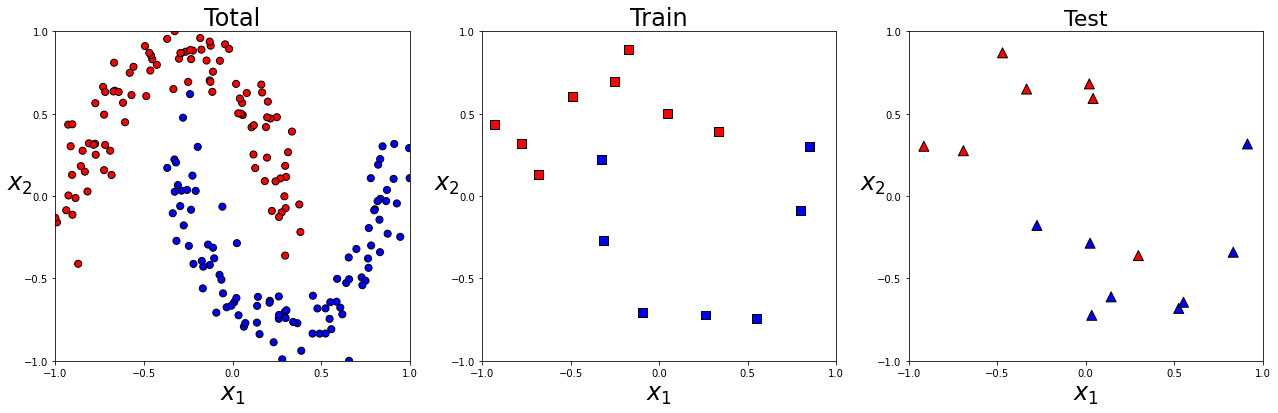

In [2]:
# Sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.datasets import make_moons
np.random.seed(seed)

# Total number of the dataset points
n_samples = 200
X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=seed)
y = 2*y-1 # rescale to [-1,1]

# Data rescaling
xmin = -1; xmax = 1
X = MinMaxScaler(feature_range=(xmin, xmax), copy=False).fit_transform(X)

train_size = 15 
test_size = 15 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=train_size, 
                                                    test_size=test_size,
                                                    stratify=y,
                                                    random_state=seed)

# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=24)
plot_dataset(X, y, ax1, axes)

ax2.set_title("Train", fontsize=24)
plot_dataset(X_train, y_train, ax2, axes, marker='s', size=80)

ax3.set_title("Test", fontsize=22)
plot_dataset(X_test, y_test, ax3, axes, marker='^', size=100)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

# RBF SVM

## Training

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 100, 1000],
}

clf = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
)
clf.fit(X_train, y_train)

print('Best grid search parameters:', clf.best_params_)
print('Best training score:', clf.best_score_)

Best grid search parameters: {'C': 1, 'gamma': 5.0}
Best training score: 0.8541666666666666


## Predictions/Decision boundaries plot

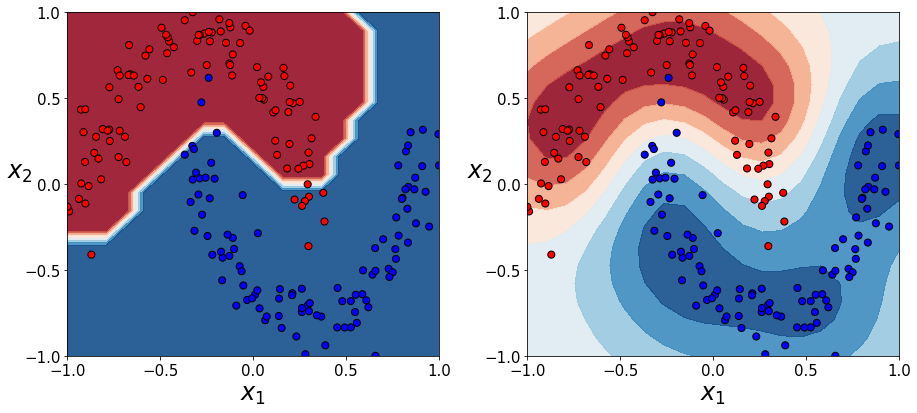

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(clf.best_estimator_, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(clf.best_estimator_, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()

## Model cross-validation

In [5]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

# train_size = 10
# test_size = 10

param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 100, 1000],
}

n_splits = 5
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
cv = StratifiedShuffleSplit(
    n_splits=n_splits, 
    train_size=train_size, test_size=test_size, 
    random_state=seed
)

i = 0
for train, test in cv.split(X, y):
    i += 1
    print(f"Train/Test CV Subset {i}")

    clf = GridSearchCV(
        estimator=SVC(kernel='rbf'),
        param_grid=param_grid,
        scoring='balanced_accuracy',
        n_jobs=1,
        refit=True,
        cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
    )
    
    clf.fit(X[train,:], y[train])
   
    train_scores = get_scores(clf.best_estimator_, X[train,:], y[train])
    test_scores = get_scores(clf.best_estimator_, X[test,:], y[test])
    scores_tr.append(train_scores)
    scores_tt.append(test_scores)
    if test_scores[scoring] > best_score:
        best_score = test_scores[scoring]
        best_clf = clf.best_estimator_

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')

Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5

==== Cross-Validation Scores ====

Best train score:  1.0

Train set:
   Balanced accuracy:  0.90 +- 0.20
                  F1:  0.87 +- 0.25
             ROC_AUC:  0.99 +- 0.03
                 MCC:  0.80 +- 0.40

Test set:
   Balanced accuracy:  0.85 +- 0.18
                  F1:  0.81 +- 0.26
             ROC_AUC:  0.99 +- 0.02
                 MCC:  0.70 +- 0.36


In [6]:
scores_ = get_scores(best_clf, X, y)
print_scores(scores_, title='Entire set:')


Entire set:
   Balanced accuracy:  0.95
                  F1:  0.95
             ROC_AUC:  1.00
                 MCC:  0.90


## Best RBF CV Predictions/Decision boundaries plot

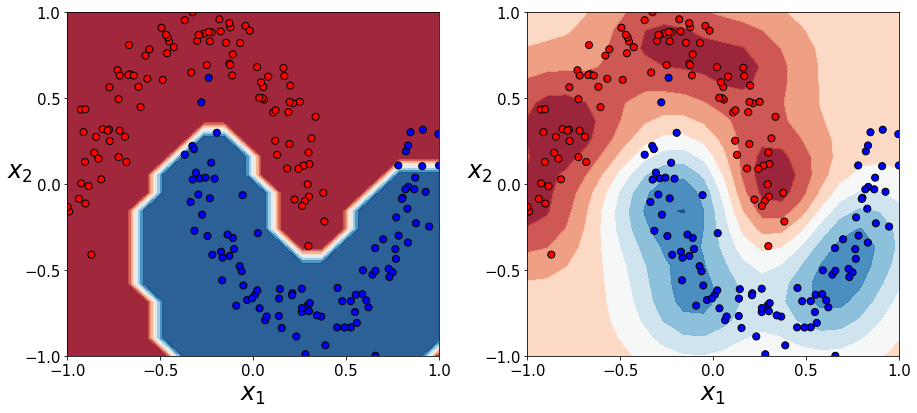

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(best_clf, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(best_clf, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()

# QKE SVM

## Setting up the quantum feature map 

In [8]:
from qksvm.QuantumFeatureMap import QuantumFeatureMap

## Specify Feature Map
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=3,
    num_layers=1,
    gates=['RY', 'cz',], entanglement='linear',
)
print(fm.draw(plot_barriers=False, fold=120))

     ┌────────────┐        
q_0: ┤ Ry(x[0]*α) ├──■─────
     ├────────────┤  │     
q_1: ┤ Ry(x[1]*α) ├──■──■──
     ├────────────┤     │  
q_2: ┤ Ry(x[0]*α) ├─────■──
     └────────────┘        


## Training

In [9]:
from qksvm.QKSVM import QSVC

qsvc = QSVC(fm, alpha=2.8, C=1.0, random_state=seed)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')


Train scores:
   Balanced accuracy:  0.93
                  F1:  0.93
             ROC_AUC:  1.00
                 MCC:  0.87

Test scores:
   Balanced accuracy:  0.93
                  F1:  0.93
             ROC_AUC:  0.96
                 MCC:  0.87


In [10]:
scores_ = get_scores(qsvc, X, y)
print_scores(scores_, title='Entire set:')


Entire set:
   Balanced accuracy:  0.93
                  F1:  0.93
             ROC_AUC:  0.98
                 MCC:  0.86


## Predictions/Decision boundaries plot

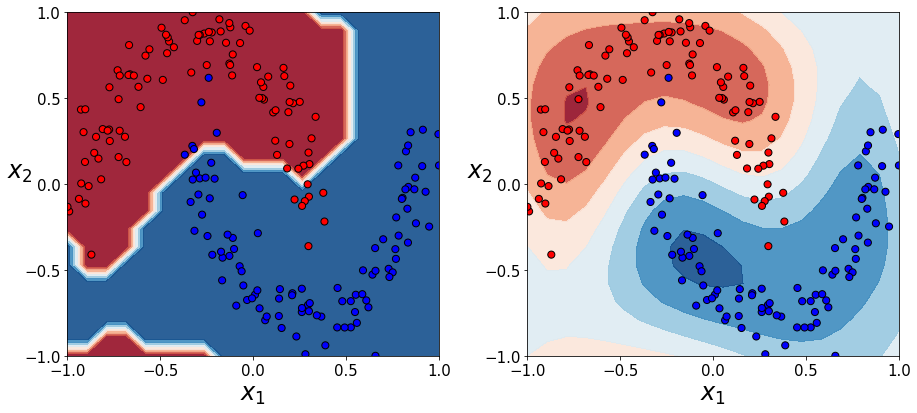

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()

## Model cross-validation

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

# train_size = 10
# test_size = 10

n_splits = 5
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
cv = StratifiedShuffleSplit(
    n_splits=n_splits, 
    train_size=train_size, test_size=test_size, 
    random_state=seed
)

i = 0
for train, test in cv.split(X, y):
    i += 1
    print(f"Train/Test CV Subset {i}")
    
    qsvc = QSVC(fm, alpha=2.8, C=1.0, random_state=seed)
    qsvc.fit(X[train,:], y[train])
   
    train_scores = get_scores(qsvc, X[train,:], y[train])
    test_scores = get_scores(qsvc, X[test,:], y[test])
    scores_tr.append(train_scores)
    scores_tt.append(test_scores)
    if test_scores[scoring] > best_score:
        best_score = test_scores[scoring]
        best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')

Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5

==== Cross-Validation Scores ====

Best train score:  1.0

Train set:
   Balanced accuracy:  0.99 +- 0.03
                  F1:  0.99 +- 0.03
             ROC_AUC:  1.00 +- 0.00
                 MCC:  0.97 +- 0.05

Test set:
   Balanced accuracy:  0.96 +- 0.03
                  F1:  0.96 +- 0.03
             ROC_AUC:  0.98 +- 0.02
                 MCC:  0.92 +- 0.06


In [13]:
scores_ = get_scores(best_qsvc, X, y)
print_scores(scores_, title='Best model on entire set:')


Best model on entire set:
   Balanced accuracy:  0.94
                  F1:  0.94
             ROC_AUC:  0.99
                 MCC:  0.88


## Best QSVM CV Predictions/Decision boundaries plot

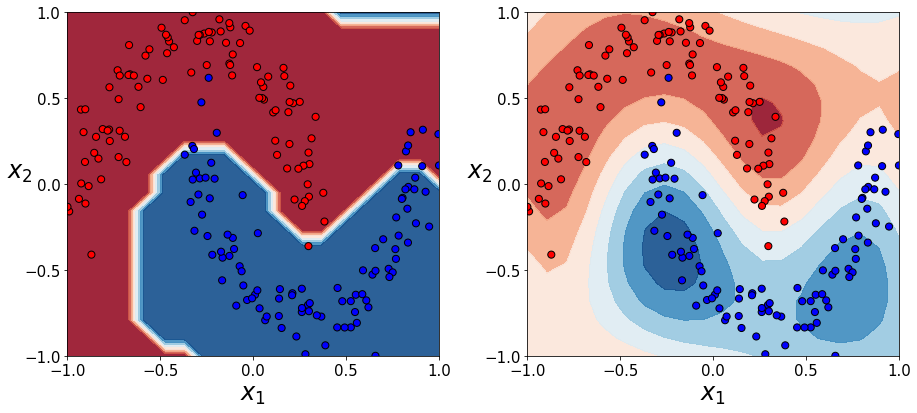

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(best_qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(best_qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()